In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from semi_supervised_manifold_learning import *
from submodular_cut_fns import *

# plt.rcParams["animation.html"] = "jshtml"
# plt.ioff()
from IPython.display import HTML


%load_ext autoreload
%autoreload 2

In [22]:
# generate new data
_, data_matrix = generate_spirals(n_pts=100, verbose = False) #start_theta=np.pi / 5, num_rotations=0.9, verbose=False)

# build a hypergraph from k-nearest-nbs of each point
k = 5
knn_hgraph_dict = build_knn_hypergraph(data_matrix, k)
n = knn_hgraph_dict['n']

star_hgraph_dict = build_knn_hypergraph_star_expansion(data_matrix, k)

knn_adj_matrix = build_knn_graph(data_matrix, k)
D = np.squeeze(np.asarray(np.sum(knn_adj_matrix,axis=0)))
G = nx.from_scipy_sparse_matrix(knn_adj_matrix)
pos = dict([(v,data_matrix[v,:]) for v in G.nodes()])

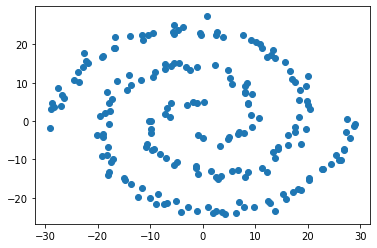

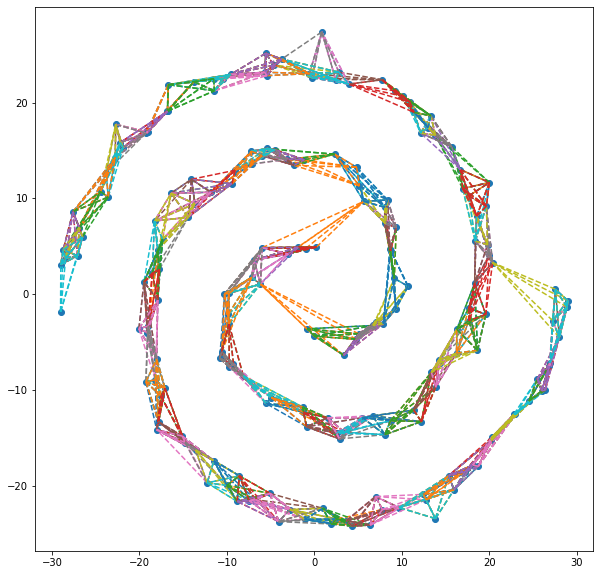

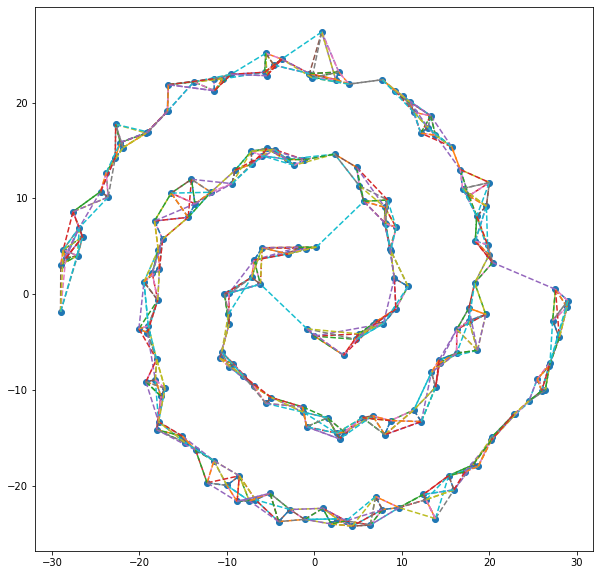

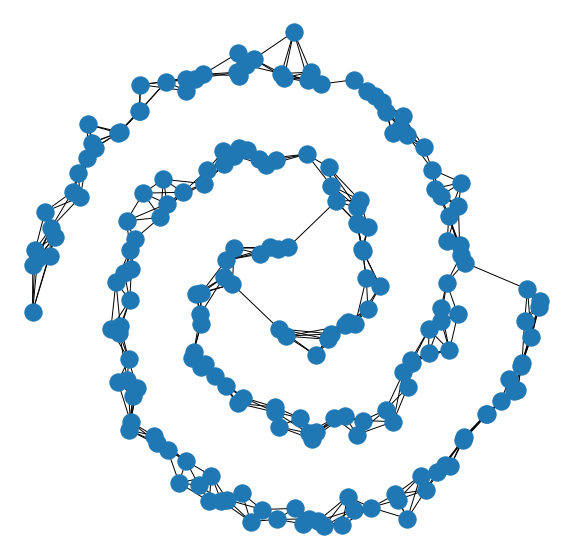

In [23]:
plt.scatter(data_matrix[:, 0], data_matrix[:, 1])
plt.show()

visualize_hyperedges(data_matrix, knn_hgraph_dict['hypergraph'])
visualize_hyperedges(data_matrix, star_hgraph_dict['hypergraph'])

fig, ax = plt.subplots(figsize = (10,10))
nx.draw(G, pos = pos, ax = ax)

In [24]:
# sample a random initial seed node
x0 = np.full(shape=(n, 1), fill_value=0)
x0[np.random.choice(n, size = 1)] = 1


In [25]:
def animate_hgraph_diffusion(data_matrix, hypergraph_dict, x0, T=49, step_size=1, verbose = False):
    # let's extract some parameters
    n = hypergraph_dict['n']
    m = hypergraph_dict['m']
    hypergraph = hypergraph_dict['hypergraph']
    degree_dict = hypergraph_dict['degree']
    D = np.array([degree_dict[v] for v in range(n)])
    
    # for our hypergraph, first specify the edge objective function
    s_vector = np.zeros_like(x0)
    
    #cut_func = diffusion_functions['infinity']
    cut_func = lambda *args, **kwargs: submodular_subgradient(cardinality_cut_fn, parallelize=False, *args, **kwargs)
    t, x, y, fx = diffusion(x0, n, m, D, hypergraph, weights=None, func=cut_func,
                            s=s_vector, h=step_size, T=T, verbose=verbose)
    
    # animate results
    fig, ax = plt.subplots(figsize = (6,6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    flat_x = np.reshape(x, newshape = (T,n))
    
    def update(frame):
        color =  flat_x[frame,:]
        im = ax.scatter(data_matrix[:, 0], data_matrix[:, 1], c =color)
        cax.cla()
        fig.colorbar(im, cax=cax)
        return im
    
    ani = animation.FuncAnimation(fig=fig, func=update, frames=T, interval=300)
    plt.close()
    
    return ani
    
def animate_graph_diffusion(data_matrix, A, D, x0, T = 49, step_size = 1.0, verbose = False):
    n = data_matrix.shape[0]
    
    x, y, fx = graph_diffusion(x0, D, A, s=None, h=step_size, T=T, verbose=verbose)
    
    # animate results
    fig, ax = plt.subplots(figsize = (6,6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    
    def update(frame):
        color =  x[frame,:]
        im = ax.scatter(data_matrix[:, 0], data_matrix[:, 1], c =color)
        cax.cla()
        fig.colorbar(im, cax=cax)
        return im
    
    ani = animation.FuncAnimation(fig=fig, func=update, frames=T, interval=300)
    plt.close()
    
    return ani
    

In [26]:
ani = animate_hgraph_diffusion(data_matrix, knn_hgraph_dict, x0)

HTML(ani.to_html5_video())

In [28]:
ani = animate_hgraph_diffusion(data_matrix, star_hgraph_dict, x0)

HTML(ani.to_html5_video())

In [29]:
ani = animate_graph_diffusion(data_matrix, knn_adj_matrix, D, x0)

HTML(ani.to_html5_video())